# Data Processing

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Process Data

### Step 1 - Split matches into point segments

Starting from the full match videos and the annotations, we split them into shorter segments containing a single point.

In [2]:
# Import libraries
import os
import json
import cv2
from tqdm import tqdm

In [3]:
# Constants
from __init__ import data_path
# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
videos_path = os.path.join(dataset_path, "videos")
annotations_path = os.path.join(dataset_path, "annotations")

# Read videos
videos = sorted(os.listdir(videos_path))
print("___VIDEOS___")
for video in videos: print(video)

# Determine where to save segments
segments_path = os.path.join(dataset_path, "segments_alt")
os.makedirs(segments_path, exist_ok=True)

___VIDEOS___
V006.mp4
V007.mp4
V008.mp4
V009.mp4
V010.mp4


In [3]:
def segment_video(
    video, 
    segment_by="Point", 
    videos_path=videos_path, 
    annotations_path=annotations_path, 
    segments_path=segments_path,
    overwrite=False,
):
    # Video & annotation path
    video_name, video_ext = os.path.splitext(video)
    video_path = os.path.join(videos_path, video)
    annotation_path = os.path.join(annotations_path, video.replace(video_ext, ".json"))

    # Load annotation
    with open(annotation_path) as annotation_file:
        annotation = json.load(annotation_file)

    # Load video
    capture = cv2.VideoCapture(video_path)
    frame = 0

    # Get resolution & framerate from capture
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = capture.get(cv2.CAP_PROP_FPS)

    # Perform segmentation
    segments = annotation["classes"][segment_by]
    for index, segment in tqdm(enumerate(segments)):
        # Determine path to save current segment
        segment_nr = f"{index}".zfill(4)
        segment_name = f"{video_name}_{segment_nr}"
        segment_path = os.path.join(segments_path, f"{segment_name}.mp4")

        # Don't overwrite if not needed
        if os.path.exists(segment_path) and not overwrite:
            continue

        # Open video writer
        writer = cv2.VideoWriter(segment_path, cv2.VideoWriter_fourcc(*"avc1"), fps, (frame_width, frame_height))

        # segment points
        start, end = int(segment["start"]), int(segment["end"])

        # Fast forward to start of segment
        frame = start
        capture.set(1, frame)
        
        # Save frames to segment
        while_safety = 0
        max_while_safety = 500
        while frame < end:
            # Read frame
            ret, img = capture.read()

            # Sometimes OpenCV reads None's during a video, in which case we want to just skip
            assert while_safety < max_while_safety, f"ERROR, cv2 read {max_while_safety} Nones"
            if ret == 0 or img is None: 
                while_safety += 1
                continue 
            while_safety = 0

            # Write frame
            writer.write(img)

            # Increase frame counter
            frame += 1
        
        # Release writer
        writer.release()
    

In [ ]:
segment_video(videos[0], overwrite=True)

In [ ]:
for video in videos:
    print(f"Segmenting video {video}")
    segment_video(video, overwrite=True)

In [ ]:
segment_files = [f for f in os.listdir(segments_path) if f.endswith('.mp4')]
n_segments = len(segment_files)
total_frames = 0
total_duration = 0
for segment in segment_files:
    segment_path = os.path.join(segments_path, segment)
    # Give the duration and number of frames of the video
    data = cv2.VideoCapture(segment_path) 
    frames = data.get(cv2.CAP_PROP_FRAME_COUNT) 
    fps = data.get(cv2.CAP_PROP_FPS)
    
    # calculate duration of the video 
    duration = frames / fps

    # Add to total
    total_frames += frames
    total_duration += duration

print(f"Total number of videos: {n_segments}")
print(f"Total number of frames: {total_frames}")
print(f"Total duration: {total_duration / 60 / 60:.2f} hours")
print(f"Average duration per video: {total_duration / n_segments:.2f} seconds")

### Step 2 - Court, Player & Ball Detection

In [2]:
# Import libaries
import os
import sys
import cv2
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

We make use of the pre-trained models provided by the tennis-project repository:
- [Ball Detection](https://drive.google.com/file/d/1XEYZ4myUN7QT-NeBYJI0xteLsvs-ZAOl/view): Save as `models/data/ball_detection/model.pt`
- [Court Detection](https://drive.google.com/file/d/1f-Co64ehgq4uddcQm1aFBDtbnyZhQvgG/view): Save as `models/data/court_detection/model.pt`

In [44]:
# Constants
from __init__ import data_path, models_path

# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
segments_path = os.path.join(dataset_path, "segments_alt")
labels_path = os.path.join(dataset_path, "labels_alt")
os.makedirs(labels_path, exist_ok=True)

# Model paths
model_ball_detection_path = os.path.join(models_path, "ball_detection", "model.pt")
model_court_detection_path = os.path.join(models_path, "court_detection", "model.pt")
assert os.path.exists(model_ball_detection_path), "Please download model"
assert os.path.exists(model_court_detection_path), "Please download model"

In [45]:
# Import tennis-project objects
cwd = os.getcwd()
tennis_project_path = os.path.abspath(os.path.join(cwd, "tennis-project"))
sys.path.append(tennis_project_path)
from court_detection_net import CourtDetectorNet
from court_reference import CourtReference
from bounce_detector import BounceDetector
from person_detector import PersonDetector
from ball_detector import BallDetector
from utils import scene_detect
from main import read_video
from main import get_court_img

In [46]:
# Read segment files
segment_files = [file for file in sorted(os.listdir(segments_path)) if os.path.splitext(file)[-1] == ".mp4"]
print(f"Number of segment files: {len(segment_files)}")

Number of segment files: 44


In [70]:
def process_segment(
    segment_path, 
    labels_path = labels_path, 
    verbose = True,
):
    # Start
    start_time = time.time()
    if verbose: print("Processing segment: ", os.path.basename(segment_path))

    # Read video
    if verbose: print("Reading video")
    frames, fps =  read_video(segment_path)
    frames = frames
    video_time = time.time()
    if verbose: print(f"Done reading {len(frames)} video frames ({video_time - start_time} s)")

    # Load models
    if verbose: print("Loading models")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    ball_detector = BallDetector(model_ball_detection_path, device)
    court_detector = CourtDetectorNet(model_court_detection_path, device)
    person_detector = PersonDetector(device)
    models_time = time.time()
    if verbose: print(f"Done loading models ({models_time - video_time} s)")

    # Detect court 
    if verbose: print("Detecting court")
    homography_matrices, kps_court = court_detector.infer_model(frames)
    court_time = time.time()
    if verbose: print(f"Done detecting court ({court_time - models_time} s)")

    # Detect people
    if verbose: print("Detecting people")
    persons_top, persons_bottom = person_detector.track_players(frames, homography_matrices, filter_players=False)
    people_time = time.time()
    if verbose: print(f"Done detecting people ({people_time - court_time} s)")

    # Detect ball trajectory
    if verbose: print("Detecting ball trajectory")
    ball_track = ball_detector.infer_model(frames)
    ball_time = time.time()
    if verbose: print(f"Done detecting ball trajectory ({ball_time - people_time} s)")

    # Export labels
    if verbose: print("Saving results")
    segment_dir, segment_filename = os.path.split(segment_path)
    segment_name, segment_ext = os.path.splitext(segment_filename)
    # Save court
    court_file = os.path.join(labels_path, f"{segment_name}_court.npy")
    court_sequence = np.squeeze(np.array(kps_court))
    np.save(court_file, court_sequence)
    # Save players
    for player_name, player_sequence in zip(["btm", "top"], [persons_bottom, persons_top]):
        player_file = os.path.join(labels_path, f"{segment_name}_player_{player_name}_bbox.npy")
        player_sequence = np.array([item[0][0] for item in player_sequence])
        np.save(player_file, player_sequence)
    # Save ball trajectory
    ball_file = os.path.join(labels_path, f"{segment_name}_ball.npy")
    ball_sequence = np.array(ball_track)
    np.save(ball_file, ball_sequence)
    save_time = time.time()
    if verbose: print(f"Done detecting ball trajectory ({save_time - ball_time} s)")

In [69]:
process_segment(os.path.join(segments_path, segment_files[0]))

Processing segment:  V006_0000.mp4
Reading video
Done reading 25 video frames (0.09086918830871582 s)
Loading models


/home/florsanders/anaconda3/envs/teco/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/florsanders/anaconda3/envs/teco/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/25 [00:00<?, ?it/s]

Done loading models (0.9107072353363037 s)
Detecting court


  0%|          | 0/25 [00:00<?, ?it/s]

Done detecting court (59.230350971221924 s)
Detecting people


  0%|          | 0/23 [00:00<?, ?it/s]

Done detecting people (97.96948552131653 s)
Detecting ball trajectory


100%|██████████| 23/23 [00:49<00:00,  2.16s/it]

Done detecting ball trajectory (49.664159297943115 s)


In [78]:
def read_segment_labels(
    segment_path,
    labels_path=labels_path,
    load_court=True,
    load_ball=True,
    load_player_bbox=True,
):
    # Parse segment name
    segment_dir, segment_filename = os.path.split(segment_path)
    segment_name, segment_ext = os.path.splitext(segment_filename)

    # Read labels
    court_sequence = None
    ball_sequence = None
    player_btm_bbox_sequence = None
    player_top_bbox_sequence = None
    # Load court
    if load_court:
        court_path = os.path.join(labels_path, f"{segment_name}_court.npy")
        court_sequence = np.load(court_path, allow_pickle=True)
    # Load ball
    if load_ball:
        ball_path = os.path.join(labels_path, f"{segment_name}_ball.npy")
        ball_sequence = np.load(ball_path, allow_pickle=True)
    # Load player bounding boxes
    if load_player_bbox:
        player_btm_bbox_path = os.path.join(labels_path, f"{segment_name}_player_btm_bbox.npy")
        player_btm_bbox_sequence = np.load(player_btm_bbox_path, allow_pickle=True)
        player_top_bbox_path = os.path.join(labels_path, f"{segment_name}_player_top_bbox.npy")
        player_top_bbox_sequence = np.load(player_top_bbox_path, allow_pickle=True)
    
    # Return labels
    return court_sequence, ball_sequence, player_btm_bbox_sequence, player_top_bbox_sequence

In [83]:
def visualize_frame_annotations(
    frame,
    court_points,
    ball_point,
    player_btm_bbox,
    player_top_bbox,
    show_court_numbers=False,
    show_img = False,
):
    # Copy frame
    img = frame.copy()

    # Show court points
    for i, (x, y) in enumerate(court_points):
        if x is None or y is None:
            continue
        img = cv2.circle(img, (int(x), int(y)), 5, (0, 0, 255), 5)
        if show_court_numbers:
            img = cv2.putText(img, str(i), (int(x) + 15, int(y) - 15),  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    
    # Show ball
    x, y = ball_point
    if x is not None and y is not None:
        img = cv2.circle(img, (int(x), int(y)), 5, (0, 180, 255), 5)
    
    # Show player bounding boxes
    for bbox in [player_btm_bbox, player_top_bbox]:
        x1, y1, x2, y2 = bbox
        img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    #  Show image
    if show_img:
        fig, ax = plt.subplots()
        ax.imshow(img[:,:,::-1])
        plt.show()
    
    return img

In [84]:
def visualize_segment_labels(
    segment_path, 
    out_path=None,
    labels_path=labels_path,
):
    # Parse segment name
    segment_dir, segment_filename = os.path.split(segment_path)
    segment_name, segment_ext = os.path.splitext(segment_filename)
    
    # Read frames
    frames, fps = read_video(segment_path)
    assert frames is not None and len(frames), "Segment could not be read"
    frame_height, frame_width, _ = frames[0].shape

    # Read labels
    court_sequence, ball_sequence, player_btm_bbox_sequence, player_top_bbox_sequence = read_segment_labels(segment_path, labels_path=labels_path)

    # Video writer
    fourcc = cv2.VideoWriter_fourcc(*"avc1")
    default_out_path =  os.path.join(segment_dir, f"{segment_name}_annotated.mp4")
    out_path = out_path if out_path is not None else default_out_path
    writer = cv2.VideoWriter(out_path, fourcc, fps, (frame_width, frame_height))

    # Visualize & write video
    for frame_index, frame in enumerate(frames):
        frame = visualize_frame_annotations(
            frame, 
            court_sequence[frame_index], 
            ball_sequence[frame_index], 
            player_btm_bbox_sequence[frame_index], 
            player_top_bbox_sequence[frame_index],
            show_court_numbers=True,
            show_img=frame_index==0
        )
        writer.write(frame)
    
    # Release video
    writer.release()

    return out_path

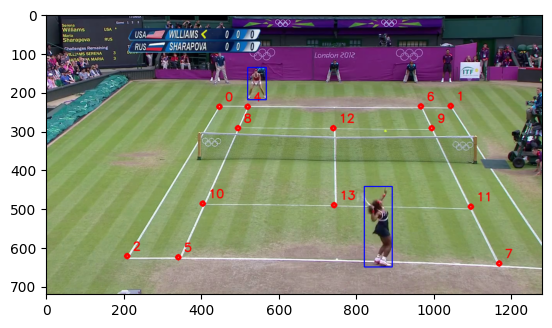

/home/florsanders/Code/columbia_university/advanced_deep_learning/adl_ai_tennis_coach/data/tenniset/segments_alt/V006_0000_annotated.mp4


In [86]:
out_path = visualize_segment_labels(os.path.join(segments_path, segment_files[0]))
print(out_path)

In [9]:
# Start video writer
fourcc = cv2.VideoWriter_fourcc(*"avc1")
fps = 25
frame_height, frame_width, _ = frames[0].shape
writer = cv2.VideoWriter("./video.mp4", fourcc, fps, (frame_width, frame_height))

for frame_index, frame in tqdm(enumerate(frames)):
    # if frame_index > 5:
    #     break
    annotated_frame = visualize_frame_annotations(
        frame,
        kps_court[frame_index],
        persons_bottom[frame_index],
        persons_top[frame_index],
        ball_track[frame_index],
        show_court_numbers=False,
        show_img=
    )

    writer.write(annotated_frame)

writer.release()

244it [00:01, 164.51it/s]


### Step 3 - Player Pose Detection